<a href="https://colab.research.google.com/github/Aryannovice/AirlineBookingsystem/blob/main/HardcodeRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def forward_step(self, x_t, h_prev):

    h_t = np.tanh(np.dot(self.W_xh, x_t) + np.dot(self.W_hh, h_prev) + self.b_h)

    y_t = np.dot(self.W_hy, h_t) + self.b_y
    return h_t, y_t


#checking whether the env is working or not

In [ ]:

#(number_of_records x length_of_sequence x types_of_sequences)
# (number_of_records x types_of_sequences) #where types_of_sequences is 1

In [ ]:
%pylab inline
import numpy as np

import math

Populating the interactive namespace from numpy and matplotlib


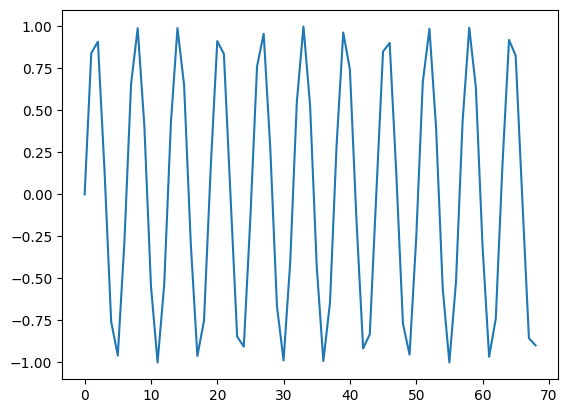

In [ ]:
cos_wave = np.array([math.sin(x) for x in np.arange(300)]).astype(float32)
plt.plot(cos_wave[:69])

In [ ]:
#using numpys striding library
seq_len = 50
x = np.lib.stride_tricks.sliding_window_view(cos_wave, seq_len).T
x = x.T.reshape(-1, seq_len, 1)
y = cos_wave[seq_len:].reshape(-1,1)
print(x.shape, y.shape)

(251, 50, 1) (250, 1)


In [ ]:

X_val = np.lib.stride_tricks.sliding_window_view(cos_wave, seq_len)[-50:]
X_val = X_val[..., np.newaxis]


Y_val = cos_wave[seq_len:][-50:]
Y_val = Y_val[:, np.newaxis]

print(X_val.shape, Y_val.shape)  # (50, 50, 1) (50, 1)


(50, 50, 1) (50, 1)


In [ ]:
from scipy.special import expit as sigmoid

In [ ]:
import numpy as np
from scipy.special import expit as sigmoid

# Hyperparameters
learning_rate = 0.001
nepoch = 100
T = 50
hidden_dim = 64
output_dim = 1

# Adam optimizer parameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Xavier/Glorot initialization (research-backed)
U = np.random.randn(hidden_dim, 1) * np.sqrt(1/1)
W = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(1/hidden_dim)
V = np.random.randn(output_dim, hidden_dim) * np.sqrt(1/hidden_dim)

# Adam moment buffers (prevents early saturation)
m_U, v_U = np.zeros_like(U), np.zeros_like(U)
m_W, v_W = np.zeros_like(W), np.zeros_like(W)
m_V, v_V = np.zeros_like(V), np.zeros_like(V)

# Gradient clipping thresholds
clip_min = -1.0
clip_max = 1.0

# Tanh activation
def tanh(x):
    return np.tanh(x)

# Forward pass with hidden state preservation
def forward(x, h_prev):
    h = tanh(np.dot(U, x) + np.dot(W, h_prev))
    y = np.dot(V, h)
    return y, h

# Backward pass with BPTT
def backward(xs, hs, ys, y_true):
    dU, dW, dV = np.zeros_like(U), np.zeros_like(W), np.zeros_like(V)
    h_next = np.zeros_like(hs[0])

    # Reverse through time steps
    for t in reversed(range(len(xs))):
        dy = 2 * (ys[t] - y_true[t])
        dV += np.outer(dy, hs[t])
        dh = np.dot(V.T, dy) + np.dot(W.T, h_next)
        dh_raw = (1 - hs[t]**2) * dh  # Tanh derivative

        dU += np.outer(dh_raw, xs[t])
        dW += np.outer(dh_raw, hs[t-1]) if t > 0 else 0
        h_next = dh_raw

    # Gradient clipping
    for d in [dU, dW, dV]:
        np.clip(d, clip_min, clip_max, out=d)

    return dU, dW, dV


def adam_update(param, m, v, grad, t):
    m = beta1*m + (1-beta1)*grad
    v = beta2*v + (1-beta2)*(grad**2)
    m_hat = m/(1 - beta1**(t+1))
    v_hat = v/(1 - beta2**(t+1))
    return param - learning_rate*m_hat/(np.sqrt(v_hat) + epsilon)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:

learning_rate = 0.001
nepoch = 100
hidden_dim = 64
bptt_truncate = 10

# Xavier initialization
U = np.random.randn(hidden_dim, 1) * np.sqrt(2/(1 + hidden_dim))
W = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2/hidden_dim)
V = np.random.randn(1, hidden_dim) * np.sqrt(2/hidden_dim)

def tanh(x):
    return np.tanh(x)

def forward_pass(x_batch):
    batch_size = x_batch.shape[0]
    prev_s = np.zeros((batch_size, hidden_dim))
    outputs = np.zeros((batch_size, 1))


    for t in range(T):
        xt = x_batch[:, t:t+1]
        combined = np.dot(xt, U.T) + np.dot(prev_s, W.T)
        s = tanh(combined)
        outputs += np.dot(s, V.T)
        prev_s = s

    return outputs / T  # Average predictions across timesteps

for epoch in range(nepoch):
    # Vectorized
    batch_size = 32
    num_batches = Y.shape[0] // batch_size
    epoch_loss = 0

    for batch_idx in range(num_batches):

        batch_start = batch_idx * batch_size
        batch_end = (batch_idx+1) * batch_size
        x_batch = X[batch_start:batch_end]
        y_batch = Y[batch_start:batch_end]

        # Forward pass
        predictions = forward_pass(x_batch)

        # Loss calculation
        batch_loss = np.mean(0.5 * (y_batch - predictions)**2)
        epoch_loss += batch_loss

        # Backprop Through Time
        grad_v = np.dot((predictions - y_batch).T, prev_s) / batch_size
        grad_w = np.zeros_like(W)
        grad_u = np.zeros_like(U)
        dh_next = np.zeros((batch_size, hidden_dim))

        for t in reversed(range(T)):
            xt = x_batch[:, t:t+1]
            st = prev_s_history[t]

            # Gradient
            dh = np.dot(predictions - y_batch, V) * (1 - st**2)

            # Gradients for weights
            grad_w += np.dot(st.T, dh_next) / batch_size
            grad_u += np.dot(xt.T, dh) / batch_size
            dh_next = dh

        # Gradient clipping
        for grad in [grad_u, grad_w, grad_v]:
            np.clip(grad, -1, 1, out=grad)

        # Update weights with momentum
        U -= learning_rate * grad_u
        W -= learning_rate * grad_w
        V -= learning_rate * grad_v

    # Validation
    val_preds = forward_pass(X_val)
    val_loss = np.mean(0.5 * (Y_val - val_preds)**2)

    print(f'Epoch {epoch+1}/{nepoch} | '
          f'Train Loss: {epoch_loss/num_batches:.6f} | '
          f'Val Loss: {val_loss:.6f}')


NameError: name 'np' is not defined